# Random Forest

### Data Preprocessing

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.base import clone

# Read training and testing data, using the first column as the row index and the first row as the column names
train_data = pd.read_excel('US_PCE_training.xlsx', index_col=0)
test_data = pd.read_excel('US_PCE_testing_fake.xlsx', index_col=0)

# Extract PCE data
train_pce = train_data.iloc[0, :] 
test_pce = test_data.iloc[0, :] 

# Combine PCE data and calculate the inflation rate
combined_pce = pd.concat([train_pce, test_pce]).astype(float)
combined_inflation_rate = np.log(combined_pce).diff() * 12  
combined_inflation_rate = combined_inflation_rate.dropna()

# Split the training and testing inflation rates
train_inflation_rate = combined_inflation_rate.iloc[:len(train_pce)-1]
test_inflation_rate = combined_inflation_rate.iloc[len(train_pce)-1:]

# Extract feature variables
train_features = train_data.iloc[4:].T 
test_features = test_data.iloc[3:].T

combined_features = pd.concat([train_features, test_features]).astype(float)
combined_predictors = np.log(combined_features).diff() * 12
combined_predictors = combined_predictors.dropna()

train_predictors = combined_predictors.iloc[:len(train_features)-1,:] 
test_predictors = combined_predictors.iloc[len(train_features)-1:,]

# Normalize features
scaler = StandardScaler()
train_predictors_scaled = scaler.fit_transform(train_predictors)
test_predictors_scaled = scaler.transform(test_predictors)
train_predictors_scaled = pd.DataFrame(train_predictors_scaled,index=train_predictors.index,columns=train_predictors.columns)
test_predictors_scaled = pd.DataFrame(test_predictors_scaled,index=test_predictors.index,columns=test_predictors.columns)

### Model Training and In-Sample Fitting

In [5]:
def prepare_data(features, target, n_lags, horizon):
    X, y = [], []
    # Loop over the indices of the target array that allow for both lags and horizon
    for i in range(n_lags + horizon, len(target)):
        start_idx = i - horizon - n_lags
        end_idx = i - horizon
        feature_set = features.iloc[start_idx:end_idx].to_numpy().flatten()  # Lagged predictor features
        target_lags = target.iloc[start_idx:end_idx].to_numpy().flatten()  # Lagged values of the target variable  
        X.append(np.hstack([feature_set, target_lags]))
        # Append the actual target value for the corresponding time point 'i' to the target list
        y.append(target.iloc[i])
    return np.array(X), np.array(y)

In [6]:
def perform_random_forest(X, y, n_splits, param_grid):
    # Initialize the Time Series Cross-Validator
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_score = float('inf')
    best_params = {}

    # Iterate over all possible combinations of parameters in the parameter grid
    for params in ParameterGrid(param_grid):
        model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
        scores = []

        for train_idx, test_idx in tscv.split(X):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = mean_squared_error(y_test, y_pred)
            scores.append(score)

        avg_score = np.mean(scores)
        if avg_score < best_score:
            best_score = avg_score
            best_params = params

    # Re-fit the model with the best parameters found on the entire dataset
    model.set_params(**best_params)
    model.fit(X, y)
    return model, best_score, best_params

Horizon 1: Best CV MSE 0.0007638457073226545, Best Params {'max_depth': 10, 'n_estimators': 100}


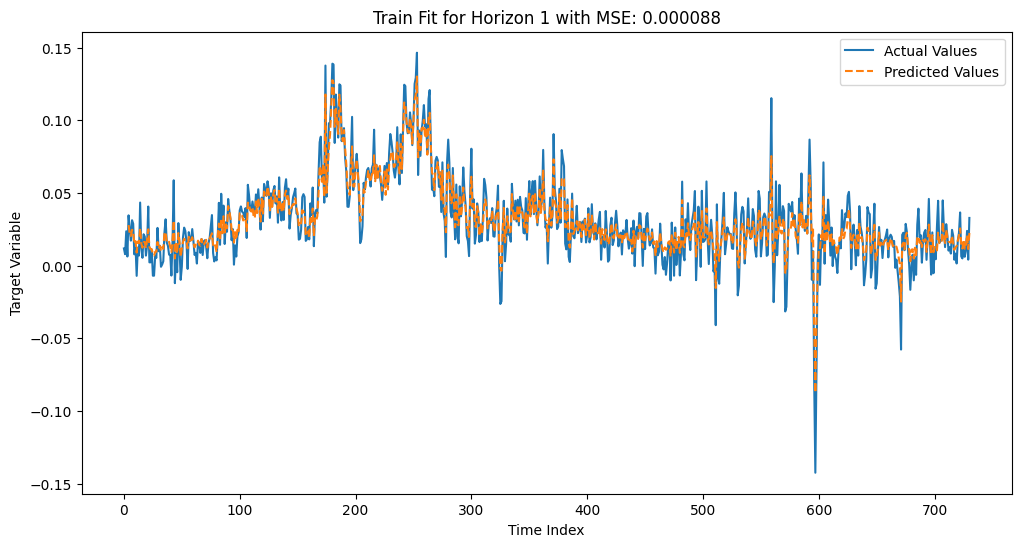

Horizon 3: Best CV MSE 0.0007663975987406811, Best Params {'max_depth': 10, 'n_estimators': 100}


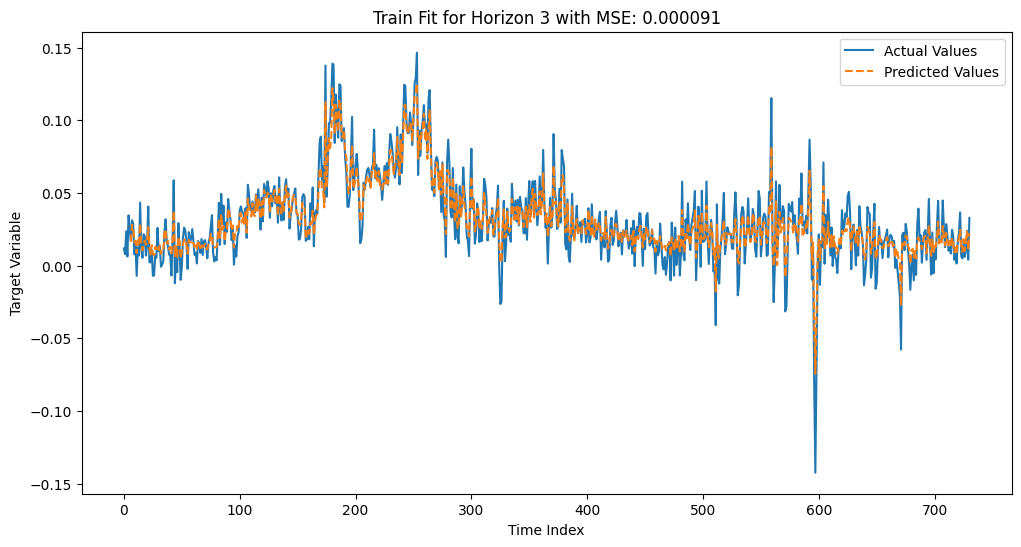

Horizon 12: Best CV MSE 0.0009153265259572076, Best Params {'max_depth': 10, 'n_estimators': 150}


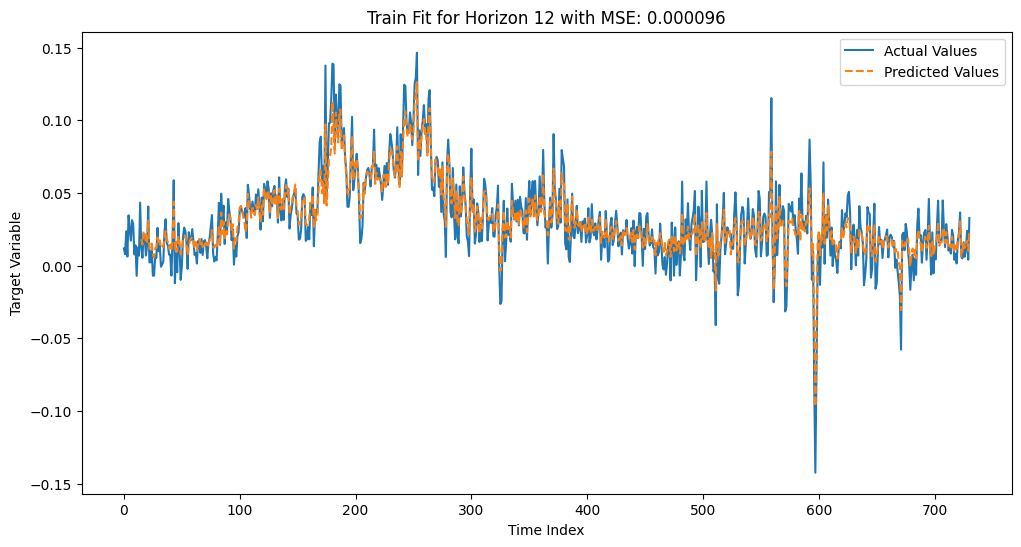

In [7]:
n_lags = 3
horizons = [1, 3, 12]

# Set the parameter grid for tuning the RandomForest model
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [10, 20, 30]  # Maximum depth of each tree
}
n_splits = 5

models = {}
for horizon in horizons:
    X, y = prepare_data(train_predictors, train_inflation_rate, n_lags, horizon)
    model, best_score, best_params = perform_random_forest(X, y, n_splits, param_grid)
    models[horizon] = model
    print(f"Horizon {horizon}: Best CV MSE {best_score}, Best Params {best_params}")

    # Predict on the training dataset to evaluate fit
    y_pred = model.predict(X)

    # Calculate Mean Squared Error on the training dataset
    train_mse = mean_squared_error(y, y_pred)

    # Prepare a plot to visualize actual values and predictions
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_inflation_rate)), train_inflation_rate, label='Actual Values')
    # Plot predictions with an offset
    pred_start = n_lags + horizon
    plt.plot(range(pred_start, pred_start + len(y_pred)), y_pred, label='Predicted Values', linestyle='--')
    plt.title(f'Train Fit for Horizon {horizon} with MSE: {train_mse:.6f}')
    plt.xlabel('Time Index')
    plt.ylabel('Target Variable')
    plt.legend()
    plt.show()

### Pseudo Out-of-Sample Prediction

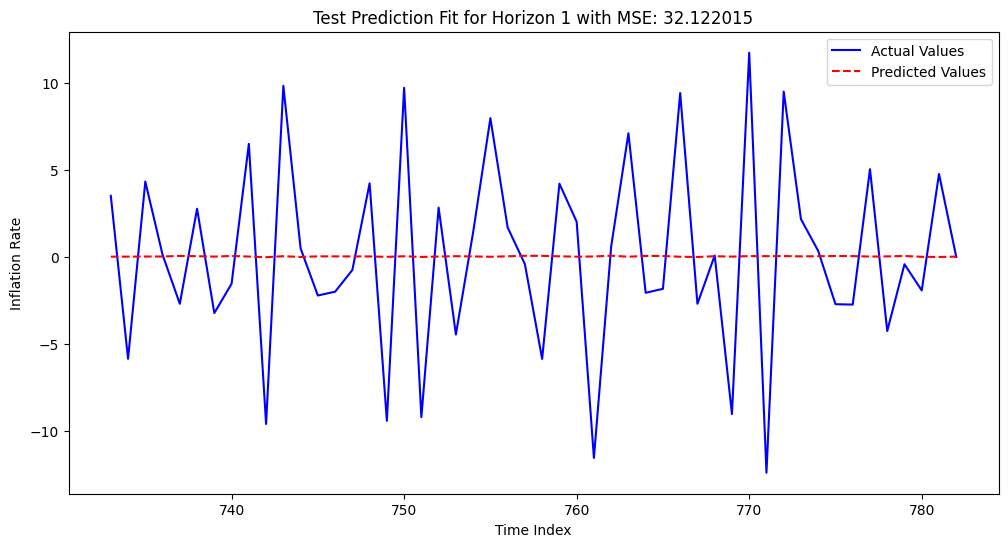

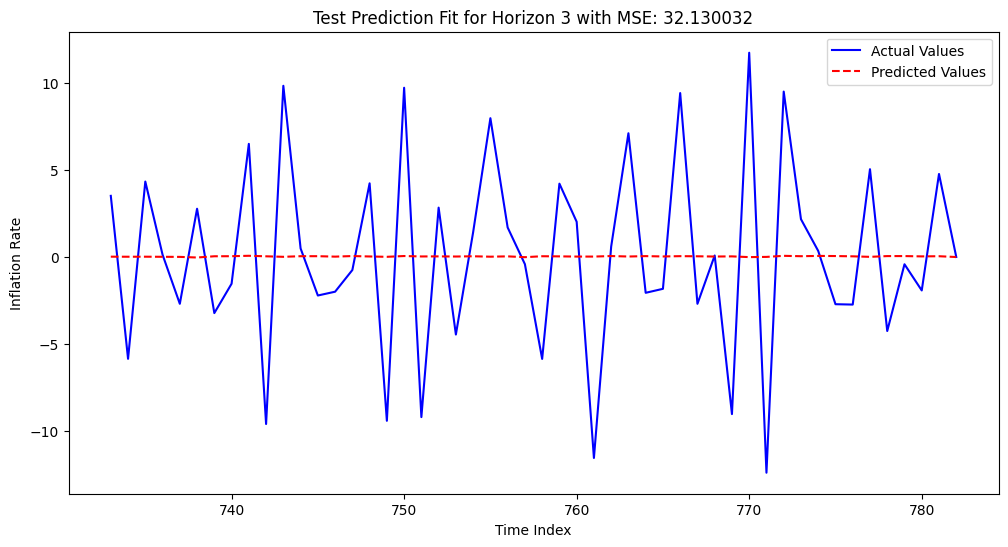

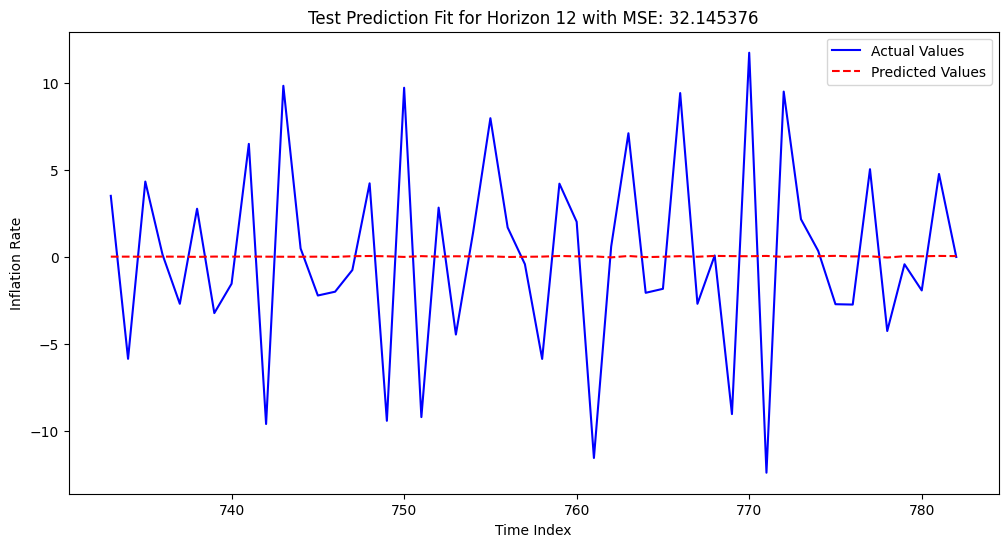

In [11]:
def prepare_test_data(train_features, train_target, test_features, test_target, n_lags, horizon):
    # Extend test features by including sufficient training set tail data to handle lag and horizon
    combined_features = pd.concat([train_features.iloc[-(n_lags + horizon):], test_features])
    combined_target = pd.concat([train_target.iloc[-(n_lags + horizon):], test_target])
    
    X_test, y_test = [], []
    # Start index is after the initial n_lags + horizon to form a complete first set of features
    start_index = n_lags + horizon

    # Iterate through combined data to form feature and target sets for testing
    for i in range(start_index, len(combined_target)):
        start_idx = i - n_lags - horizon
        end_idx = i - horizon
        # Flatten feature sets to create a single array per sample
        feature_set = combined_features.iloc[start_idx:end_idx].to_numpy().flatten()
        target_lags = combined_target.iloc[start_idx:end_idx].to_numpy().flatten()
        
        X_test.append(np.hstack([feature_set, target_lags]))
        y_test.append(combined_target.iloc[i])

    return np.array(X_test), np.array(y_test)

test_mses = {}
for horizon in horizons:
    X_test, y_test = prepare_test_data(train_predictors, train_inflation_rate, test_predictors, test_inflation_rate, n_lags, horizon)
    model = models[horizon]  # Retrieve the model trained for this specific horizon
    
    y_pred_test = model.predict(X_test)
    test_mses[horizon] = mean_squared_error(y_test, y_pred_test)

    end_idx = len(combined_inflation_rate)  
    start_idx = end_idx - 50  

    plt.figure(figsize=(12, 6))
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_test, label='Actual Values', color='blue')
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_pred_test, label='Predicted Values', linestyle='--', color='red')
    plt.title(f"Test Prediction Fit for Horizon {horizon} with MSE: {test_mses[horizon]:.6f}")
    plt.xlabel('Time Index')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

## Trial with Block Bootstrap

In [148]:
def block_bootstrap(data, block_size, n_blocks):
    sample_indices = []
    n_samples = len(data)
    for _ in range(n_blocks):
        # Randomly choose the starting point for each block
        start = np.random.randint(0, n_samples - block_size)
        indices = list(range(start, start + block_size))
        sample_indices.extend(indices)
    return np.array(sample_indices)

def manual_grid_search(X, y, param_grid, block_size, n_splits=4):
    best_score = float('inf')
    best_params = None
    best_model = None
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            mse_scores = []
            for train_idx, test_idx in tscv.split(X):
                # Reinitialize the model for each iteration
                model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, bootstrap=False, n_jobs=-1)
                models = []
                
                # Perform block bootstrap for each tree in the forest
                for _ in range(n_estimators):
                    bootstrap_indices = block_bootstrap(train_idx, block_size, min(10, len(train_idx) // block_size))
                    X_train = X[bootstrap_indices]
                    y_train = y[bootstrap_indices]
                    tree = clone(model)
                    tree.fit(X_train, y_train)
                    models.append(tree)
                
                # Ensemble model prediction on the test set
                X_test = X[test_idx]
                y_test = y[test_idx]
                y_pred = np.mean([tree.predict(X_test) for tree in models], axis=0)
                mse = mean_squared_error(y_test, y_pred)
                mse_scores.append(mse)

            average_mse = np.mean(mse_scores)
            print(f"Testing model with n_estimators={n_estimators}, max_depth={max_depth}, MSE={average_mse}")
            if average_mse < best_score:
                best_score = average_mse
                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}

    best_model = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=42, bootstrap=False, n_jobs=-1)
    best_model.fit(X, y)
                
    return best_params, best_score, best_model

n_lags = 3
block_size = 36
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, 30]
}
horizons = [1, 3, 12]
models = {}
for horizon in horizons:
    print(f"Training model for {horizon}-month ahead prediction:")
    X, y = prepare_data(train_predictors, train_inflation_rate, n_lags, horizon)
    best_params, best_score, best_model = manual_grid_search(X, y, param_grid, block_size)
    models[horizon] = best_model
    print(f"Best Parameters for Horizon {horizon}: {best_params}")
    print(f"Best MSE for Horizon {horizon}: {best_score}")

Training model for 1-month ahead prediction:
Testing model with n_estimators=50, max_depth=10, MSE=0.0009356556923383478
Testing model with n_estimators=50, max_depth=20, MSE=0.0009310271872912239
Testing model with n_estimators=50, max_depth=30, MSE=0.0009142441713180181
Testing model with n_estimators=100, max_depth=10, MSE=0.0009295706610358914
Testing model with n_estimators=100, max_depth=20, MSE=0.0009326200132063232
Testing model with n_estimators=100, max_depth=30, MSE=0.0009309882465174965
Best Parameters for Horizon 1: {'n_estimators': 50, 'max_depth': 30}
Best MSE for Horizon 1: 0.0009142441713180181
Training model for 3-month ahead prediction:
Testing model with n_estimators=50, max_depth=10, MSE=0.001006426234349551
Testing model with n_estimators=50, max_depth=20, MSE=0.0010058159306551545
Testing model with n_estimators=50, max_depth=30, MSE=0.0009594194656955069
Testing model with n_estimators=100, max_depth=10, MSE=0.0009953945132829894
Testing model with n_estimators=